# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

P(X == 6) ≈ 0.165860  (95% CI: [0.163555, 0.168165])


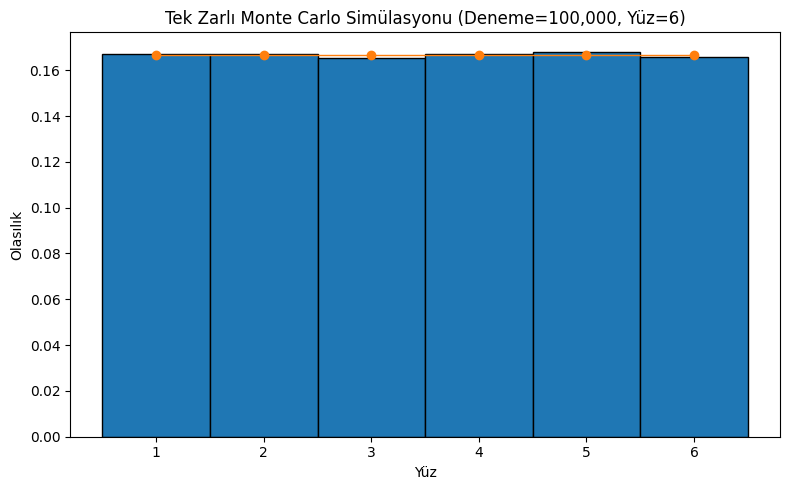

OSError: Cannot save file into a non-existent directory: '/mnt/data'

In [3]:
# Single-die Monte Carlo simulation in a notebook-friendly cell
# - Plots a histogram of outcomes
# - Prints estimated probabilities and a 95% CI for P(face == target)
# - Saves a CSV of frequencies to /mnt/data and shows a small table
#
# You can re-run this cell after changing the parameters below.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import isclose

# =====================
# Parameters (edit me)
# =====================
trials = 100000       # number of rolls
sides  = 6             # die faces
seed   = 42            # RNG seed (None for random)
probs  = None          # e.g., [0.05,0.10,0.15,0.20,0.20,0.30] for a biased 6-sided die
target = 6             # compute P(X == target); set to None to skip CI

# ==============
# Simulation
# ==============
rng = np.random.default_rng(seed)

if probs is not None:
    probs = np.asarray(probs, dtype=float)
    if probs.size != sides:
        raise ValueError(f"`probs` must have length == sides ({sides}).")
    s = probs.sum()
    if not isclose(s, 1.0, rel_tol=1e-10, abs_tol=1e-10):
        probs = probs / s  # normalize if slightly off
    if (probs < 0).any():
        raise ValueError("All probabilities must be non-negative.")
    rolls = rng.choice(np.arange(1, sides+1), size=trials, p=probs)
else:
    rolls = rng.integers(1, sides+1, size=trials)

# Frequencies and probabilities
values, counts = np.unique(rolls, return_counts=True)
freq = pd.DataFrame({
    "Face": values,
    "Count": counts,
    "Estimated_Prob": counts / counts.sum()
}).set_index("Face")

# Optional CI for a specific target
def proportion_ci_wald(p_hat: float, n: int, z: float = 1.959963984540054):
    se = np.sqrt(max(p_hat * (1 - p_hat), 0.0) / n)
    return max(0.0, p_hat - z*se), min(1.0, p_hat + z*se)

if target is not None:
    hits = (rolls == target).sum()
    p_hat = hits / trials
    lo, hi = proportion_ci_wald(p_hat, trials)
    print(f"P(X == {target}) ≈ {p_hat:.6f}  (95% CI: [{lo:.6f}, {hi:.6f}])")

# Theoretical probabilities (uniform or user-provided probs)
if probs is None:
    theo = np.full(sides, 1.0/sides)
else:
    theo = probs

# Merge theoretical for comparison
theo_df = pd.DataFrame({"Theoretical_Prob": theo}, index=np.arange(1, sides+1))
out = freq.join(theo_df, how="right")
out["Count"] = out["Count"].fillna(0).astype(int)
out["Estimated_Prob"] = out["Estimated_Prob"].fillna(0.0)

# =====================
# Plot: Histogram (PDF)
# =====================
plt.figure(figsize=(8, 5))
# Histogram with bins centered on integers
bins = np.arange(0.5, sides + 1.5, 1)
plt.hist(rolls, bins=bins, density=True, edgecolor="black")
plt.xticks(np.arange(1, sides + 1, 1))
plt.xlabel("Yüz")
plt.ylabel("Olasılık")
plt.title(f"Tek Zarlı Monte Carlo Simülasyonu (Deneme={trials:,}, Yüz={sides})")

# Add theoretical probabilities as markers/lines
# (uses default matplotlib style; no explicit colors set)
x = np.arange(1, sides + 1)
plt.plot(x, theo, marker="o", linewidth=1)

plt.tight_layout()
plt.show()

# =====================
# Save & Display Table
# =====================
csv_path = "/mnt/data/die_sim_results.csv"
out.to_csv(csv_path, index=True)

# Show a small table to the user
from caas_jupyter_tools import display_dataframe_to_user
display_dataframe_to_user("Die Simulation Frequencies (Face, Count, Estimated_Prob, Theoretical_Prob)", out.round(6))

csv_path


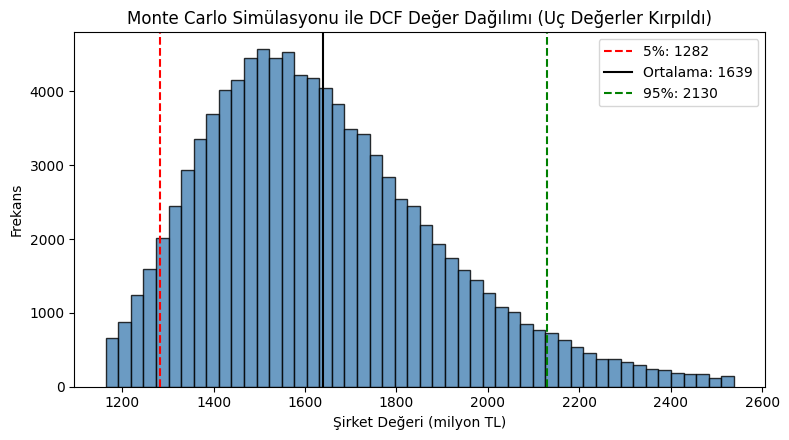

('dcf_monte_carlo_histogram_clean.png',
 (np.float64(1282.458134068021),
  np.float64(1602.7027613652222),
  np.float64(2129.8405650964073),
  np.float64(1639.1950980501047)))

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Daha anlaşılır bir DCF Monte Carlo simülasyonu

# Parametreler
n_sim = 100000
cash_flow0 = 100  # milyon TL
years = 5

rng = np.random.default_rng(42)

# Dağılımlar
growth_rates = rng.normal(0.05, 0.02, (n_sim, years))   # %5 ± %2
discount_rates = rng.normal(0.10, 0.01, n_sim)          # %10 ± %1
terminal_growth = rng.normal(0.03, 0.005, n_sim)        # %3 ± %0.5

dcf_values = []
for i in range(n_sim):
    cf = cash_flow0
    pv = 0
    for t in range(1, years+1):
        cf *= (1 + growth_rates[i, t-1]) #Cash flow büyümesi her yıl için growth_rate ile çarpılır
        pv += cf / ((1 + discount_rates[i]) ** t) # İndirgenmiş nakit akışları toplanır
    # Terminal value yalnızca WACC > g ise hesaplansın
    if discount_rates[i] > terminal_growth[i]:
        tv = (cf * (1 + terminal_growth[i])) / (discount_rates[i] - terminal_growth[i]) # Terminal value hesaplanır cf'nin son yıl değeri ile terminal growth kullanılarak WACC - g ile bölünür
        pv += tv / ((1 + discount_rates[i]) ** years) # Terminal value'nun bugünkü değeri hesaplanır ve pv'ye eklenir
    dcf_values.append(pv) #dcf_values listesine bugünkü değer eklenir

dcf_values = np.array(dcf_values) # numpy array'e dönüştürülür

# Uç değerleri kırpalım (örneğin 1. ve 99. persentil arası)
low, high = np.percentile(dcf_values, [1, 99])
filtered_values = dcf_values[(dcf_values >= low) & (dcf_values <= high)]

# İstatistikler
p5, p50, p95 = np.percentile(filtered_values, [5, 50, 95])
mean_val = np.mean(filtered_values)

# Histogram
plt.figure(figsize=(8, 4.5))
plt.hist(filtered_values, bins=50, color="steelblue", edgecolor="black", alpha=0.8)
plt.axvline(p5, linestyle="--", color="red", label=f"5%: {p5:.0f}")
plt.axvline(mean_val, linestyle="-", color="black", label=f"Ortalama: {mean_val:.0f}")
plt.axvline(p95, linestyle="--", color="green", label=f"95%: {p95:.0f}")
plt.title("Monte Carlo Simülasyonu ile DCF Değer Dağılımı (Uç Değerler Kırpıldı)")
plt.xlabel("Şirket Değeri (milyon TL)")
plt.ylabel("Frekans")
plt.legend()

dcf_clean_path = "dcf_monte_carlo_histogram_clean.png"
plt.tight_layout()
plt.savefig(dcf_clean_path, dpi=200)
plt.show()

dcf_clean_path, (p5, p50, p95, mean_val)


# Üstteki kodun açıklaması:
# Bu kod, bir şirketin değerini Monte Carlo simülasyonu kullanarak tahmin etmek için DCF (Discounted Cash Flow) yöntemini uygular. İşte kodun detaylı açıklaması:
# 1. **Parametreler**: Simülasyon için gerekli parametreler tanımlanır. `n_sim` simülasyon sayısını, `cash_flow0` başlangıç nakit akışını ve `years` projeksiyon süresini belirtir.
# 2. **Rastgele Sayı Üretici**: `numpy` kütüphanesinin `default_rng` fonksiyonu kullanılarak rastgele sayı üreteci oluşturulur.
# 3. **Dağılımlar**: Nakit akış büyüme oranları growth rates, iskonto oranları(WACC) ve terminal büyüme oranları için normal dağılımlar oluşturulur. Bu dağılımlar simülasyon boyunca kullanılacak rastgele değerleri sağlar.
# 4. **DCF Hesaplaması**: Her simülasyon için nakit akışları hesaplanır ve bugünkü değerleri (PV) toplanır. Terminal değeri yalnızca iskonto oranı terminal büyüme oranından büyükse hesaplanır.
# 5. **Uç Değerlerin Kırpılması**: Hesaplanan DCF değerlerinden uç değerler (1. ve 99. persentil dışındakiler) çıkarılır, böylece analiz daha anlamlı hale gelir.